## 3. Implementierung der Hauptkomponentenanalyse

Wir beginnen zunächst mit einem schon bekannten Datensatz *Boston Housing*. Zur praktischen Berechnung der Hauptkomponentenanalyse gehen Sie folgt vor:

1. Gegeben eine Menge von $n$ $d$-dimensionalen Datenpunkten $\mathbf{x}_i$, berechnen Sie zuerst deren Mittelwert $\boldsymbol{\mu}_x = \frac{1}{n} \sum_{i=1}^n \mathbf{x}_i$ für jedes einzelne Merkmal und ziehen ihn von allen Datenpunkten ab (Zentrierung).
2. Normieren Sie dann alle Merkmale so, dass sie eine Varianz von 1 haben. Dieser Schritt ist optional, aber meist vorteilhaft.
3. Kopieren Sie alle $\mathbf{x}_i$ als Reihen in eine $n \times d$-Matrix $X$, die sog. Daten- oder Designmatrix.
4. Zur Lösung des Eigenwertproblens berechnen Sie die Singulärwertzerlegung von $X$ (z.B. mit `numpy.linalg.svd()`): $$ X = UDV^\top $$
Wer nicht weiß, was eine Singuärwertzerlegung ist oder macht, der lese bitte in den entsprechenden Wikipedia-Einträgen nach. Im Prinzip könnte man auch direkt die Eigenwerte der Kovarianzmatrix (s. Folie 12) berechnen (z.B. mit `numpy.linalg.eig()`), diese Methode ist aber meist aufwändiger und numerisch weniger stabil.
5. Die ersten $r$ Basisvektoren $\mathbf{q}_i$  (d.h die ersten $r$ Hauptkomponenten) sind die ersten $r$ Spalten der orthogonalen $d \times d$-Matrix $V$.
6. Die Projektionen $a_i$ der Daten $\mathbf{x}_i$ auf die ersten $r$ Basisvektoren $\mathbf{q}_i$ (d.h die neuen Variablenwerte im neuen Koordinatensystem) sind die die ersten $r$ Spalten der $n \times d$-Matrix $UD$.
7. Die Standardabweichungen entlang der Hauptkomponenten $\mathbf{q}_i$ sind die Diagonalelemente der Diagonalmatrix $D$ geteilt durch $\sqrt{n - 1}$.

Aufgaben:

a) Implementieren Sie ein Python-Modul, das eine Funktion zur Hauptkomponentenanalyse nach obigem Schema zur Verfügung stellt.

In [2]:
import numpy as np

def pca(X, r=1, normalize=True):
    # 1. Zentrierung
    mu_x = np.mean(X, axis=0)
    X_centered = X - mu_x

    # 2. Normalisierung
    if normalize:
        std_x = np.std(X_centered, axis=0, ddof=1)
        X_normalized = X_centered / std_x
    else:
        X_normalized = X_centered

    # 3. Designmatrix ist X_normalized

    # 4. Singulärwertzerlegung
    U, S, Vt = np.linalg.svd(X_normalized, full_matrices=False)
    D = np.diag(S)

    # 5. Auswahl der ersten r Hauptkomponenten
    Q_r = Vt.T[:, :r]

    # 6. Projektionen auf die ersten r Hauptkomponenten
    A_r = U[:, :r] @ D[:r, :r]

    # 7. Standardabweichungen entlang der Hauptkomponenten
    std_dev_r = S[:r] / np.sqrt(X.shape[0] - 1)

    return Q_r, A_r, std_dev_r

b) Testen Sie Ihr Modul innerhalb eines IPython-Notebooks am Datensatz *Boston Housing*. Lassen Sie dabei die Variable `TGT` weg. Stellen Sie Ihre Ergebnisse in einer Tabelle mit den Eigenwerten der Kovarianzmatrix (Achtung: die Diagonalelemente von $D$ müssen dafür quadriert und durch n − 1 geteilt werden. Warum?), dem Anteil der zugehörigen Hauptkomponente an an der Gesamtvarianz (“erklärte Varianz”) und der kumulativen erklärten Varianz dar, d.h. welchen Varianzanteil die ersten $n$ Komponenten zusammen erklären. Wieviele Dimensionen können Sie weglassen, wenn Sie 10%, 5% und 1% Fehler bei der Dimensionsreduktion zulassen?

In [3]:
import pandas as pd
import numpy as np

# -------------------------------------------------------------
# 1. Boston Housing Daten laden (ohne TGT)
# -------------------------------------------------------------
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
cols = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','TGT']
boston = pd.read_csv(url, sep=' ', skipinitialspace=True, header=None, names=cols, index_col=False)

boston_data = boston.drop(columns=['TGT'])
X = boston_data.values
# X = boston.drop(columns=['TGT']).to_numpy()
n, d = X.shape
print(f"Anzahl Datenpunkte: {n}, Anzahl Merkmale: {d}")

# -------------------------------------------------------------
# 2. PCA durchführen
# -------------------------------------------------------------
V_r, A_r, std_pcs = pca(X, r= n,  normalize=True)

# -------------------------------------------------------------
# 3. Eigenwerte der Kovarianzmatrix berechnen
# -------------------------------------------------------------
eigenvalues = (std_pcs ** 2)  # weil std_pcs = D / sqrt(n-1)
total_variance = np.sum(eigenvalues)
explained_variance_ratio = eigenvalues / total_variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

results = pd.DataFrame({
    "Eigenwert": eigenvalues,
    "Erklärte Varianz": explained_variance_ratio,
    "Kumulative erklärte Varianz": cumulative_explained_variance
})

pd.set_option('display.float_format', lambda x: f'{x:.6f}')
display(results)

# -------------------------------------------------------------
# Analyse: Wie viele Dimensionen können weggelassen werden?
# -------------------------------------------------------------
# Ziel: mindestens 90%, 95%, 99% Varianz beibehalten
thresholds = [0.90, 0.95, 0.99]

for t in thresholds:
    retained = np.argmax(cumulative_explained_variance >= t) + 1
    dropped = d - retained
    error = 1 - t
    print(f"Für höchstens {error*100:.0f}% Fehler: {retained} Dimensionen behalten, {dropped} weglassen.")


Anzahl Datenpunkte: 506, Anzahl Merkmale: 13


,Eigenwert,Erklärte Varianz,Kumulative erklärte Varianz
0,6.126849,0.471296,0.471296
1,1.433275,0.110252,0.581548
2,1.242617,0.095586,0.677134
3,0.857575,0.065967,0.743101
4,0.834816,0.064217,0.807318
5,0.657407,0.050570,0.857888
6,0.535356,0.041181,0.899069
7,0.396097,0.030469,0.929538
8,0.276943,0.021303,0.950841
9,0.220238,0.016941,0.967783


Für höchstens 10% Fehler: 8 Dimensionen behalten, 5 weglassen.
Für höchstens 5% Fehler: 9 Dimensionen behalten, 4 weglassen.
Für höchstens 1% Fehler: 12 Dimensionen behalten, 1 weglassen.


c) Berechnen Sie die Matrix der Korrelationskoeffizienten für die transformierten Variablen und interpretieren Sie das Ergebnis.

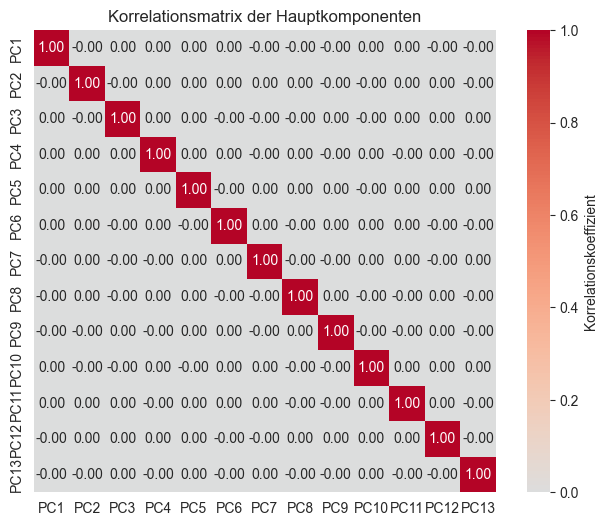

In [4]:
corr_matrix = np.corrcoef(A_r, rowvar=False)  # Spalten = Variablen
corr_df = pd.DataFrame(corr_matrix,
                       columns=[f"PC{i+1}" for i in range(A_r.shape[1])],
                       index=[f"PC{i+1}" for i in range(A_r.shape[1])])

# display(corr_df.round(3))

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", center=0, fmt=".2f",
            square=True, cbar_kws={'label': 'Korrelationskoeffizient'})
plt.title("Korrelationsmatrix der Hauptkomponenten")
plt.show()

Die Heatmap zeigt, dass die Hauptkomponenten praktisch unkorreliert sind – die Diagonalelemente liegen bei 1, die übrigen nahe 0.
Damit bestätigt sich, dass PCA die Daten in ein neues, orthogonales Koordinatensystem transformiert, in dem jede Komponente unabhängige Varianzanteile beschreibt.

d) Berechnen Sie den Korrelationskoeffizienten der Projektionen auf die ersten drei Hauptkomponenten mit den ursprünglichen Variablen. Interpretieren Sie Ihr Ergebnis.

,PC1,PC2,PC3
CRIM,0.621000,-0.377000,0.275000
ZN,-0.634000,-0.387000,0.330000
INDUS,0.858000,0.135000,-0.018000
CHAS,0.012000,0.545000,0.323000
NOX,0.849000,0.262000,0.135000
RM,-0.468000,0.179000,0.662000
AGE,0.776000,0.373000,-0.020000
DIS,-0.796000,-0.418000,-0.055000
RAD,0.792000,-0.325000,0.320000
TAX,0.838000,-0.287000,0.246000


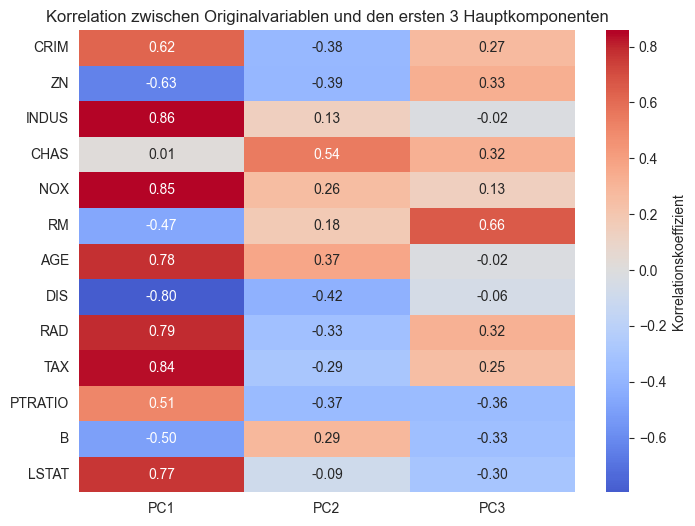

In [5]:
corrs = np.zeros((X.shape[1], 3))  # 13 Variablen × 3 PCs

for i in range(X.shape[1]):
    for j in range(3):
        corrs[i, j] = np.corrcoef(X[:, i], A_r[:, j])[0, 1]

corr_df = pd.DataFrame(corrs, index=boston_data.columns, columns=["PC1", "PC2", "PC3"])

display(corr_df.round(3))

plt.figure(figsize=(8,6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", center=0, fmt=".2f",
            cbar_kws={'label': 'Korrelationskoeffizient'})
plt.title("Korrelation zwischen Originalvariablen und den ersten 3 Hauptkomponenten")
plt.show()

Die Heatmap zeigt, welche ursprünglichen Variablen stark mit den ersten drei Hauptkomponenten korrelieren.
Variablen mit hohen positiven oder negativen Werten prägen die jeweilige Komponente besonders stark.
Damit lässt sich erkennen, dass PC1 die Merkmale mit der größten Gesamtvarianz (z. B. Wohnqualität und sozioökonomische Faktoren) zusammenfasst, während PC2 und PC3 orthogonale, unabhängige Muster dieser Datenstruktur beschreiben.

e. Stellen Sie die ersten beiden der neuen Variablen als Scatterplot dar (am besten in Pandas-Dataframe importieren). Plotten Sie dabei alle Datenpunkte mit einem Hauspreis oberhalb des Medians aller Hauspreise in einer anderen Farbe als die Datenpunkte unterhalb. Eignen sich die beiden neuen Variablen zur Vorhersage des Hauspreises?

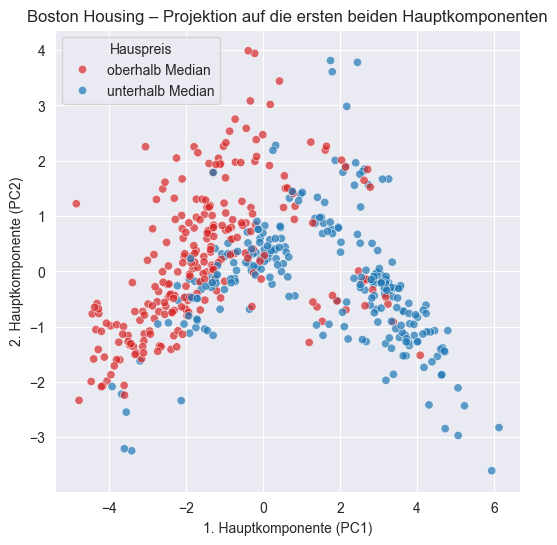

In [6]:
pc_df = pd.DataFrame(A_r[:, :2], columns=['PC1', 'PC2'])
pc_df['TGT'] = boston['TGT'].values

# 2. Hauspreis-Median berechnen
median_price = np.median(pc_df['TGT'])
pc_df['HighPrice'] = np.where(pc_df['TGT'] > median_price,
                              'oberhalb Median', 'unterhalb Median')

# 3. Scatterplot erstellen
plt.figure(figsize=(6,6))
sns.scatterplot(
    data=pc_df,
    x='PC1', y='PC2',
    hue='HighPrice',
    palette={'oberhalb Median': 'tab:red', 'unterhalb Median': 'tab:blue'},
    alpha=0.7
)
plt.title('Boston Housing – Projektion auf die ersten beiden Hauptkomponenten')
plt.xlabel('1. Hauptkomponente (PC1)')
plt.ylabel('2. Hauptkomponente (PC2)')
plt.legend(title='Hauspreis')
plt.show()

In [7]:
import plotly.express as px
import numpy as np
import pandas as pd

# Erstelle DataFrame mit den ersten 3 PCs und der Zielvariable
pc_df = pd.DataFrame(A_r[:, :3], columns=['PC1', 'PC2', 'PC3'])
pc_df['TGT'] = boston['TGT'].values
median_price = np.median(pc_df['TGT'])
pc_df['HighPrice'] = np.where(pc_df['TGT'] > median_price, 'oberhalb Median', 'unterhalb Median')

# 3D-Scatterplot
fig = px.scatter_3d(
    pc_df,
    x='PC1', y='PC2', z='PC3',
    color='HighPrice',
    color_discrete_map={'oberhalb Median': 'red', 'unterhalb Median': 'blue'},
    hover_data={'TGT': True},
    opacity=0.8,
    title='Boston Housing – Projektion auf die ersten drei Hauptkomponenten'
)
fig.update_layout(legend_title_text='Hauspreis')
fig.show()




In [8]:
# python
fig = px.scatter_3d(
    pc_df,
    x='PC1', y='PC2', z='PC3',
    color='HighPrice',
    color_discrete_map={'oberhalb Median': 'red', 'unterhalb Median': 'blue'},
    hover_data={'TGT': True},
    opacity=0.8,
    title='Boston Housing – Projektion auf die ersten drei Hauptkomponenten'
)

# Punkte kleiner machen (z.B. Größe 3)
fig.update_traces(marker=dict(size=3))

fig.update_layout(legend_title_text='Hauspreis')
fig.show()

In [9]:
%load_ext version_information
%version_information numpy, pandas

Software versions
Python 3.9.7 64bit [MSC v.1929 64 bit (AMD64)]
IPython 8.18.1
OS Windows 10 10.0.26100 SP0
numpy 2.0.2
pandas 2.3.3
Tue Oct 28 13:24:58 2025 Mitteleuropäische Zeit